In [0]:
%pip install -i https://pypi.ap.burberry.com sd-data
%pip install holidays==0.24
%pip install prophet==1.1.2

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Looking in indexes: https://pypi.ap.burberry.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 44.8 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.9/499.9 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: holidays
    Found existing installation: holidays 0.27.1
    Not uninstalling holidays at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-4804c71b-87e8-4acb-ab5b-a5b45c0ddae4
    Can't uninstall 'holidays'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fol

In [0]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.3 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [0]:
import pandas as pd
import numpy as np
#import networkx as nx
import seaborn as sns
from pyspark.sql.window import Window
from pyspark.sql.functions import percent_rank, col
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from pyspark import SQLContext
import pyspark.sql
import pyspark.sql.functions as f
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.stats as sts
import statistics as st
from numpy import mean, std, absolute
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils.validation import check_consistent_length, check_array
from sklearn.decomposition import PCA

# from tslearn.clustering import TimeSeriesKMeans, silhouette_score
# from tslearn.datasets import CachedDatasets
# from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from datetime import datetime, timedelta, date
from pyspark.sql.types import DateType
from pyspark.sql.window import Window
import plotly.express as px
import plotly.figure_factory as ff
import itertools
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import random
import logging
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression


import sd_data
from sd_data import Transactions, Products, Footfall

from sd_data.transformers.core import (
    pipeline,
    add_copy,
    add_coalesce,
    add_date,
    add_translation,
    add_cast,
    add_join,
    add_material,
    add_bool_from_match,
    add_fixed_column,
    apply_fillna,
    apply_filter,
    apply_sort,
    apply_select,
    apply_distinct,
    group_first,
    group_agg,
)

hyperparameter_tuning = False
random_treatment_test = False
prios_tuning = False
normal_run = True

logging.getLogger("py4j").setLevel(logging.ERROR)

spark.conf.set("spark.sql.execution.arrow.enabled", "false")
pd.set_option("display.float_format", lambda x: "%.1f" % x)

In [0]:
dbutils.widgets.removeAll()

In [0]:
traffic_params_dictionary = {
    "data_table": "user.ahutt.harrods_data_mainline",
    "date_column": "order_date",
    "date_format": "%Y-%m-%d",
    "control_column": "store_no",
    "treatment_values": "1316|1325|2578|1300|1335",
    "control_pool_column": "store_region",
    "control_pool_values": "EMEIA",
    "kpi_column": "gross_revenue",
    "impute_stores":"1210",
    "feature_selection": "6",
    "force_controls": "",
    "top_n_percent_largest_controls": "0.25",
    "train_start": "2021-04-01",
    "train_end": "2024-01-31",
    "test_start": "2024-02-01",
    "test_end": "2024-02-29",
    "treatment_start": "2024-02-01",
    "treatment_end": "2024-02-29",
    "significance_value": "0.975",
    "change_points": "2023-08-01",
    "remove_controls_containing": "1010|1243|1000|1128|1291|1332|1289|1368|1009|1214|1020|1370", #1370 bad control
    "daily_weekly_aggregation": "daily",
    "length_of_training_output": "750",
    "clip_dates": "",
    "hyperparam_tune_bool":"True",
    "synthetic_control_df_path": "/Workspace/Users/yaxuan.shao@burberry.com/synthetic_control_data_Harrods.csv"
}
 
for key, value in traffic_params_dictionary.items():
    dbutils.widgets.text(key, value, key)

In [0]:
get_data_table = spark.table(dbutils.widgets.get("data_table"))
get_date_column = dbutils.widgets.get("date_column")
get_date_format = dbutils.widgets.get("date_format")
get_control_column = dbutils.widgets.get("control_column")
get_treatment_values = [str(store) for store in dbutils.widgets.get("treatment_values").split('|')]
get_control_pool_column = dbutils.widgets.get("control_pool_column")
get_control_pool_values = dbutils.widgets.get("control_pool_values").split('|')
get_kpi_column = dbutils.widgets.get("kpi_column")
get_impute_stores = dbutils.widgets.get("impute_stores").split('|')
get_feature_selection = int(dbutils.widgets.get("feature_selection"))
get_force_controls = dbutils.widgets.get("force_controls").split('|')
get_top_n_percent_largest_controls = float(dbutils.widgets.get("top_n_percent_largest_controls"))
get_hyperparam_tune_bool = dbutils.widgets.get("hyperparam_tune_bool")

get_train_start = datetime.strptime(dbutils.widgets.get("train_start"), get_date_format)
get_train_end = datetime.strptime(dbutils.widgets.get("train_end"), get_date_format)
get_test_start = datetime.strptime(dbutils.widgets.get("test_start"), get_date_format)
get_test_end = datetime.strptime(dbutils.widgets.get("test_end"), get_date_format)
get_treatment_start = datetime.strptime(dbutils.widgets.get("treatment_start"), get_date_format)
get_treatment_end = datetime.strptime(dbutils.widgets.get("treatment_end"), get_date_format)

get_significance_value = float(dbutils.widgets.get("significance_value"))
get_change_points = [datetime.strptime(changepoint, get_date_format) for changepoint in  dbutils.widgets.get("change_points").split('|')]
get_remove_controls_containing = dbutils.widgets.get("remove_controls_containing").split('|')
get_daily_weekly_aggregation = dbutils.widgets.get("daily_weekly_aggregation")
get_length_of_training_output = int(dbutils.widgets.get("length_of_training_output"))
get_synthetic_control_df_path  = dbutils.widgets.get("synthetic_control_df_path")
#get_clip_dates = [datetime.strptime(changepoint, get_date_format) for changepoint in  dbutils.widgets.get("clip_dates").split('|')]

In [0]:
def remove_stores_containing_phrases(df_stores, remove_stores_containing, variable):
    if variable in df_stores.columns:
        if type(remove_stores_containing) == list:
            # remove stores with name containing any of these strings i.e. " MW" or " CW" Menswear Childrenswear
            init_stores = df_stores.select(variable).distinct().count()
            for cutword in remove_stores_containing:
                print(f"trying to remove {cutword}")
                df_stores = df_stores.withColumn(
                    "contains_phrase",
                    f.when(f.col(variable).contains(cutword), True).otherwise(False),
                ).filter(f.col("contains_phrase") == False)
            stores_dropped = init_stores - df_stores.select(variable).distinct().count()
            print(f"Stores Cut by {variable}: {stores_dropped}/{init_stores}")
    else:
        pass
    return df_stores
  
def convert_dates_to_datetime(sdf, date_col, date_format):
    return sdf.withColumn(date_col, f.to_date(date_col, format=date_format))
  
def filter_top_n_largest_control_candidates(sdf, control_col, kpi_col, treatment_values, n_percent):
    window = Window.orderBy(f.col(f"{kpi_col}_size").desc())

    mean_stores = (
        sdf.filter(f.col(kpi_col).isNotNull()).filter(f.col(kpi_col) > 0).groupBy(control_col)
        .agg(f.mean(kpi_col).alias(f"{kpi_col}_size"))
        .orderBy(f.col(f"{kpi_col}_size").desc())
    ).withColumn("row_number", f.row_number().over(window))

    # Filter the DataFrame to keep the top half and rows with store_no in treatment_values
    mean_stores_filtered = mean_stores.filter(
        (f.col("row_number") <= mean_stores.count() * n_percent) |
        (f.col(control_col).isin(treatment_values))
    ).drop("row_number")

    total_controls, filtered_controls = mean_stores.select(control_col).distinct().count(), mean_stores_filtered.select(control_col).distinct().count()

    print(f"Filter Largest Controls: {total_controls} --> {filtered_controls}")

    return sdf.join(mean_stores_filtered, control_col, "inner")

def keep_top_n_percent_of_controls(sdf, relative_size_col, n_percent):
  return sdf.filter(f.col(relative_size_col)>f.col(relative_size_col))

def aggregate_pilot_stores(sdf, treated_values, control_col, date_col, kpi_col):
    # use all days of that week from all years to determine a median benchmark to compare footfall against

    print(treated_values)
    
    sdf = sdf.withColumn(
        "treated_values_and_controls",
        f.when(f.col(control_col).isin(treated_values), "Agg_Pilot_Stores").otherwise(
            f.col(control_col)
        ),
    )

    if "store_name" in sdf.columns:
        treatment_stores_included = [i[0] for i in sdf.filter(f.col("treated_values_and_controls")=='Agg_Pilot_Stores').select("store_name").distinct().collect()]

        print(f"Treatment Stores Included {treatment_stores_included}")

    return sdf.groupby([f.col("treated_values_and_controls").alias(control_col), date_col]).agg(f.sum(kpi_col).alias(kpi_col))
  
def pivot_control_values(sdf, output_cols, input_cols, group_cols, pivot_col, functions_list):
  return sdf.groupby(group_cols).pivot(pivot_col).agg(*[func(input_col).alias(output_col) for output_col, input_col, func in zip(output_cols,input_cols, functions_list)])

def remove_candidates_with_excessive_zero_days_in_treatment(sdf, threshold, control_col, kpi_col, treatment_values, treatment_start, treatment_end):
    #removes all columns with many days in the treatment period that are zero
    #threshold is 0->1 i.e 0.7 means at least 70% of treatment period is non null
    window = Window.partitionBy().orderBy(f.col(f"{kpi_col}_size").desc())

    length_of_treatment = (treatment_end - treatment_start).days

    sdf_treatment = sdf.filter(f.col(get_date_column).between(treatment_start, treatment_end))

    non_null_stores = (
    sdf.filter(f.col(get_date_column).between(treatment_start, treatment_end))
    .filter(f.col(kpi_col).isNotNull())
    .filter(f.col(kpi_col) > 0)
    .groupby(control_col)
    .agg(f.count(kpi_col).alias(f"{kpi_col}_not_zero"))
    .withColumn("non_null_days", f.col(f"{kpi_col}_not_zero") / length_of_treatment)
    ).filter(
        (f.col("non_null_days") >= -1) | (f.col(control_col).isin(treatment_values))
    )

    total_controls, filtered_controls = (
        sdf.select(control_col).distinct().count(),
        non_null_stores.select(control_col).distinct().count(),
    )

    print(
        f"Filter Non-Active in Treatment Controls: {total_controls}-->{filtered_controls}"
    )
    
    return sdf.join(non_null_stores, control_col, "inner")

def add_store_closure_index(df_pilot_daily_df, data):
    store_closure = df_pilot_daily_df.rename(columns={"order_date": "ds"}).query(
        "store_no=='Agg_Pilot_Stores'"
    )
    data = (
        data.merge(
            store_closure[["ds", "weighted_footfall_percentage", "store_size"]],
            on="ds",
            how="left",
        )
        .rename(columns={"weighted_footfall_percentage": "store_closure"})
        .fillna(0)
    )
    return data

def impute_missing_data(sdf, kpi_col, date_col):
    windowSpec = Window().partitionBy("store_no").orderBy(get_date_column)

    sdf = sdf.withColumn(kpi_col, f.when(f.col(kpi_col).isNull(), f.lag(f.col(kpi_col), 365).over(windowSpec)).otherwise(f.col(kpi_col)))

    return sdf

def significant_days(treatment_period, agg_variable):
    significantly_positive_days = list(
        treatment_period[
            treatment_period["Agg_Pilot_Stores"] > treatment_period["yhat_upper"]
        ][agg_variable].astype(str)
    )
    significantly_negative_days = list(
        treatment_period[
            treatment_period["Agg_Pilot_Stores"] < treatment_period["yhat_lower"]
        ][agg_variable].astype(str)
    )
    return significantly_positive_days, significantly_negative_days
  
def get_stats_table(
    train_results,
    test_results,
    train_results_weekly,
    test_results_weekly,
    date_grouping,
):
    train_r2_daily = r2_score(train_results["Agg_Pilot_Stores"], train_results["yhat"])
    train_MAPE_daily = mean_absolute_percentage_error(
        train_results["Agg_Pilot_Stores"], train_results["yhat"]
    )
    train_MSE_daily = mean_squared_error(
        train_results["Agg_Pilot_Stores"], train_results["yhat"]
    )
    test_r2_daily = r2_score(test_results["Agg_Pilot_Stores"], test_results["yhat"])
    test_MAPE_daily = mean_absolute_percentage_error(
        test_results["Agg_Pilot_Stores"], test_results["yhat"]
    )
    test_MSE_daily = mean_squared_error(
        test_results["Agg_Pilot_Stores"], test_results["yhat"]
    )
    train_r2_weekly = r2_score(
        train_results_weekly["Agg_Pilot_Stores"], train_results_weekly["yhat"]
    )
    train_MAPE_weekly = mean_absolute_percentage_error(
        train_results_weekly["Agg_Pilot_Stores"], train_results_weekly["yhat"]
    )
    train_MSE_weekly = mean_squared_error(
        train_results_weekly["Agg_Pilot_Stores"], train_results_weekly["yhat"]
    )
    test_r2_weekly = r2_score(
        test_results_weekly["Agg_Pilot_Stores"], test_results_weekly["yhat"]
    )
    test_MAPE_weekly = mean_absolute_percentage_error(
        test_results_weekly["Agg_Pilot_Stores"], test_results_weekly["yhat"]
    )
    test_MSE_weekly = mean_squared_error(
        test_results_weekly["Agg_Pilot_Stores"], test_results_weekly["yhat"]
    )
    if date_grouping == "daily":
        train_daily_or_weekly = "Train_Daily"
        test_daily_or_weekly = "Test_Daily"
    else:
        train_daily_or_weekly = "Train_Weekly"
        test_daily_or_weekly = "Test_Weekly"
    results = {
        f"{train_daily_or_weekly}": [train_r2_daily, train_MAPE_daily, train_MSE_daily],
        f"{test_daily_or_weekly}": [test_r2_daily, test_MAPE_daily, test_MSE_daily],
        "Train_Weekly": [train_r2_weekly, train_MAPE_weekly, train_MSE_weekly],
        "Test_Weekly": [test_r2_weekly, test_MAPE_weekly, test_MSE_weekly],
    }
    results_table = pd.DataFrame(data=results, index=["R2", "MAPE(%)", "MSE"])
    return results_table
  
def mean_absolute_percentage_error(y_true, y_pred):
    return (
        np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100
    )

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res
  
def get_confidence_interval_metrics(treatment_period):
    treatment_period["ci_diff"] = (
        treatment_period["yhat_upper"] - treatment_period["yhat_lower"]
    ) / treatment_period["yhat"]
    av_ci = treatment_period["ci_diff"].mean()
    print("Confidence Interval: ", round(float(av_ci), 4))
    return av_ci
  
def get_uplift_metrics(treatment_period, pw_diff):
    treatment_period["uplift"] = pw_diff / treatment_period["yhat"]
    mean_uplift = treatment_period["uplift"].mean()
    total_uplift = pw_diff.sum() / treatment_period["yhat"].sum()
    print(f"average daily uplift: {round(100*mean_uplift,4)}%")
    print(f"Total Uplift: {round(100*total_uplift,4)}%")
    return mean_uplift, total_uplift
  
def plot_results(
    all_results_data,
    test_start,
    test_end,
    pilot_treatment_start,
    pilot_treatment_end,
    agg_variable,
):
    all_results_data = all_results_data.rename(
        columns={"Agg_Pilot_Stores": "Treated Store", "yhat": "Untreated Control"}
    )

    fig = px.line(
        all_results_data.reset_index(),
        x=agg_variable,
        y=["Treated Store", "Untreated Control"],  # , "yhat_upper", "yhat_lower"],
    )

    fig.update_layout(
        title=f"Performance of Treatment v.s. Virtual Control Group",
        xaxis_title="Date",
        yaxis_title="Pilot Gross Revenue",
    )

    fig.add_trace(
        go.Scatter(
            x=[pilot_treatment_start, pilot_treatment_end],
            y=[0, 0],
            text=["Treatment Start", "Treatment End"],
            mode="text",
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=[pilot_treatment_start, pilot_treatment_start],
            y=[
                0,
                all_results_data.max()[["Treated Store", "Untreated Control"]].max(),
            ],
            mode="lines",
            name="Test Start",
            line=dict(
                color="brown",
                width=1,
            ),
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=[pilot_treatment_end, pilot_treatment_end],
            y=[
                0,
                all_results_data.max()[["Treated Store", "Untreated Control"]].max(),
            ],
            mode="lines",
            name="Test End",
            line=dict(
                color="brown",
                width=1,
            ),
            showlegend=False,
        )
    )
    return fig

In [0]:
def impute_missing_data(sdf, date_col, impute_stores, threshold_percentage):
  for store in impute_stores:
    if store != '':
      print("Imputing Missing/Low Data for {store}")
      window_spec = Window.orderBy(date_col).rowsBetween(-365, -365)
      mean_col = sdf.agg(f.mean(store)).collect()[0][0]
      sdf = sdf.withColumn(store,
                            f.when(((f.col(store) < threshold_percentage * mean_col) | (f.col(store).isNull())),
                                  f.lag(store, 365).over(window_spec)).otherwise(f.col(store)))
  return sdf

In [0]:
def apply_multi_filter(sdf, col_list, filter_list):
    """Apply multiple filters to the Spark DataFrame."""
    assert len(col_list) == len(filter_list)
    
    for col_name, filter_value in zip(col_list, filter_list):
        sdf = sdf.filter(f.col(col_name) == filter_value)
    
    return sdf

In [0]:
date_var = "daily"  # daily, weekly
date_dic = {"daily": get_date_column, "weekly": "fiscal_week_start"}
date_grouping = 'daily'
reindex_dic = {"daily": "D", "weekly": "W"}
date_variable = date_dic[date_var]

treatment_length = (get_treatment_end - get_treatment_start).days

renovation_days = (get_treatment_start - get_train_end).days

fiscal_weeks_and_days = spark.table("platform.xref.cal").select(
    f.col("date_dashed").alias("order_date"), "fiscal_week_start"
)

print(f"{get_train_start} -> {get_test_end}")
print(f"Treatment Stores {get_treatment_values}")

data_sdf_steps = [
    (apply_filter, f.col(get_date_column).between(get_train_start, get_test_end)),
    (apply_filter, f.col(get_control_pool_column).isin(get_control_pool_values)),
    (remove_stores_containing_phrases, get_remove_controls_containing, "store_name"),
    (remove_stores_containing_phrases, get_remove_controls_containing, get_control_column),
    (filter_top_n_largest_control_candidates, get_control_column, get_kpi_column, get_treatment_values, get_top_n_percent_largest_controls),
    (remove_candidates_with_excessive_zero_days_in_treatment, 0.7, get_control_column, get_kpi_column, get_treatment_values, get_treatment_start, get_treatment_end),
    (convert_dates_to_datetime, get_date_column, get_date_format),
    (
        aggregate_pilot_stores,
        get_treatment_values,
        get_control_column,
        get_date_column,
        get_kpi_column,
    ),
    (
        pivot_control_values,
        [get_kpi_column],
        [get_kpi_column],
        get_date_column,
        get_control_column,
        [f.sum],
    ),
    (apply_sort, [f.asc(get_date_column)]),
    (impute_missing_data, get_date_column, get_impute_stores, 0.1),
]

domain_sdf = pipeline(
    get_data_table,
    data_sdf_steps,
)

2021-04-01 00:00:00 -> 2024-02-29 00:00:00
Treatment Stores ['1316', '1325', '2578', '1300', '1335']
trying to remove 1010
trying to remove 1243
trying to remove 1000
trying to remove 1128
trying to remove 1291
trying to remove 1332
trying to remove 1289
trying to remove 1368
trying to remove 1009
trying to remove 1214
trying to remove 1020
trying to remove 1370
Stores Cut by store_name: 0/124
trying to remove 1010
trying to remove 1243
trying to remove 1000
trying to remove 1128
trying to remove 1291
trying to remove 1332
trying to remove 1289
trying to remove 1368
trying to remove 1009
trying to remove 1214
trying to remove 1020
trying to remove 1370
Stores Cut by store_no: 11/126
Filter Largest Controls: 115 --> 30
Filter Non-Active in Treatment Controls: 30-->24
['1316', '1325', '2578', '1300', '1335']
Treatment Stores Included ['Harrods London MW 2F', 'Harrods London PU', 'Harrods London CHW 4F', 'Harrods London ACC GF', 'Harrods London WW 1F']
Imputing Missing/Low Data for {store

In [0]:
display(domain_sdf)

order_date,1039,1042,1049,1050,1052,1068,1075,1086,1091,1207,1210,1247,1252,1330,1333,7006,7031,7032,7039,Agg_Pilot_Stores
2021-04-01,6956.112,1114.031,8076.907000000001,13570.599000000004,null,null,2648.064,4776.652,8482.422,6979.407000000001,2280.693,1921.0439999999999,12745.565999999999,null,3833.3190000000004,10867.238999999996,null,38340.76899999999,41871.07400000001,15029.82
2021-04-02,null,null,null,null,null,null,null,1385.9569999999999,1631.572,3783.8510000000006,1504.378,null,null,null,4877.179999999999,10801.926999999998,null,32553.232,58460.734,7236.01
2021-04-03,8008.74,4798.226000000001,23184.576999999997,13372.75,null,null,null,null,6833.303000000002,null,4359.63,4763.139,570.173,null,null,11742.733999999997,null,43609.832,34933.379,2849.0
2021-04-04,null,null,null,null,null,null,null,null,null,null,1333.328,null,null,null,null,8206.036000000002,null,23561.020999999997,43592.19000000001,null
2021-04-05,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,8850.928,null,41542.09899999999,39829.261000000006,10057.99
2021-04-06,5210.508,null,7430.758000000001,9656.769,null,null,4265.176,6045.415000000001,4245.595,8198.105000000001,4052.6150000000002,4482.439,null,null,4280.685,13748.835999999994,null,24885.733999999997,37511.929000000004,17569.989999999998
2021-04-07,2043.851,3131.568,3692.3019999999997,13742.307,5912.257,530.0,3185.952,null,1473.6789999999999,3767.588,1385.96,789.47,4236.826,null,4806.999000000001,11403.959999999997,null,20567.167999999998,49381.219000000005,12527.98
2021-04-08,877.189,4070.16,12538.440000000002,11504.332999999999,null,0.0,1620.56,692.98,1184.205,4708.059,2903.498,3333.321,3245.602,null,6315.762,8371.341,null,28736.488999999994,37987.439,9859.5
2021-04-09,6315.764999999999,2824.55,24915.345999999998,10074.406,null,null,344.8,6774.040000000002,4184.191999999999,4134.2789999999995,1710.5189999999998,4543.842,2175.431,null,6219.264,11108.045,null,38679.25899999999,71217.77899999998,13590.009999999998
2021-04-10,4114.018,8210.493,17207.661,4456.121,null,null,null,null,6710.501000000001,null,2482.447,3833.319,7245.582999999999,null,null,11495.797999999997,null,26444.666999999998,45065.95,5666.0


In [0]:
domain_df = domain_sdf.toPandas().fillna(0)
domain_df[get_date_column] = pd.to_datetime(domain_df[get_date_column])

# Standardization is used to construct the synthetic control group. However, since we're using a pre-constructed synthetic control group, this function only serves to provide the means and standard deviations needed to convert the synthetic group back to its original scale.
def standardize(df, columns):
    means = df[columns].mean()
    stds = df[columns].std()
    standardized_df = df.copy()
    standardized_df[columns] = (df[columns] - means) / stds
    return means, stds, standardized_df

treated_group = domain_df[[get_date_column, 'Agg_Pilot_Stores']]
treated_means, treated_stds, treated_group_std = standardize(treated_group, ['Agg_Pilot_Stores'])

pre_treatment_period = domain_df[domain_df[get_date_column] < get_treatment_start]
treatment_period = domain_df[(domain_df[get_date_column] >= get_treatment_start) & (domain_df[get_date_column] <= get_treatment_end)]

In [0]:
# Extract synthetic control group from a fixed path
synthetic_control_df =pd.read_csv(get_synthetic_control_df_path, index_col=get_date_column)

synthetic_control_df.index = pd.to_datetime(synthetic_control_df.index)

synthetic_control_converted  = synthetic_control_df * treated_stds.values + treated_means.values

synthetic_control_converted_pre_treatment = synthetic_control_converted[synthetic_control_converted.index < get_treatment_start]

display(synthetic_control_converted_pre_treatment)

synthetic_revenue
18393.586833632216
14099.157938481734
16710.231825695944
10507.907689519358
9781.047955577022
18348.00130700433
19389.350466602777
19810.132582277176
18603.77714229699
12651.363526974666


In [0]:
# Prepare data for Prophet
def prepare_prophet_data(df, date_col, value_col):
    return df[[date_col, value_col]].rename(columns={date_col: 'ds', value_col: 'y'})

treated_prophet_data = prepare_prophet_data(pre_treatment_period, get_date_column, 'Agg_Pilot_Stores')

synthetic_control_data = pd.DataFrame({
    'ds': synthetic_control_converted_pre_treatment.index,
    'y': synthetic_control_converted_pre_treatment['synthetic_revenue']
}).reset_index(drop=True)

treated_prophet_data['cap'] = treated_prophet_data['y'].max()*1.25
synthetic_control_data['cap'] = synthetic_control_data['y'].max()*1.25

In [0]:
display(treated_prophet_data)
display(synthetic_control_data)

ds,y,cap
2021-04-01T00:00:00Z,15029.82,208556.2125
2021-04-02T00:00:00Z,7236.01,208556.2125
2021-04-03T00:00:00Z,2849.0,208556.2125
2021-04-04T00:00:00Z,0.0,208556.2125
2021-04-05T00:00:00Z,10057.99,208556.2125
2021-04-06T00:00:00Z,17569.989999999998,208556.2125
2021-04-07T00:00:00Z,12527.98,208556.2125
2021-04-08T00:00:00Z,9859.5,208556.2125
2021-04-09T00:00:00Z,13590.009999999998,208556.2125
2021-04-10T00:00:00Z,5666.0,208556.2125


ds,y,cap
2021-04-01T00:00:00Z,18393.586833632216,132177.22774119186
2021-04-02T00:00:00Z,14099.157938481734,132177.22774119186
2021-04-03T00:00:00Z,16710.231825695944,132177.22774119186
2021-04-04T00:00:00Z,10507.907689519358,132177.22774119186
2021-04-05T00:00:00Z,9781.047955577022,132177.22774119186
2021-04-06T00:00:00Z,18348.00130700433,132177.22774119186
2021-04-07T00:00:00Z,19389.350466602777,132177.22774119186
2021-04-08T00:00:00Z,19810.132582277176,132177.22774119186
2021-04-09T00:00:00Z,18603.77714229699,132177.22774119186
2021-04-10T00:00:00Z,12651.363526974666,132177.22774119186


In [0]:
# Display the entire Pandas DataFrame
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show all column content

In [0]:
def implement_hyperparameter_tuning(
    data, param_grid, significance_value
):
    # Generate all combinations of parameters
    all_params = [
        dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())
    ]
    rmses = []  # Store the RMSEs for each parameter combination

    # Iterate through all parameter combinations
    for i in range(len(all_params)):
        # Create and fit model with given parameters
        m = Prophet(
            **all_params[i],
            interval_width=significance_value,
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            growth="logistic",
        )

        m.fit(data)

        # Cross-validation
        df_cv = cross_validation(
            m,
            horizon="30 days",
            period="30 days",
            initial="730 days",
            parallel="processes",
        )

        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p["rmse"].values[0])

    # Make a dataframe of all the parameter combinations
    tuning_results = pd.DataFrame(all_params)
    tuning_results["rmse"] = rmses

    # Find the best parameter combination
    best_params = all_params[np.argmin(rmses)]
    print(tuning_results.sort_values("rmse", ascending=True))
    print(f"BEST PARAMS: {best_params}")

    return best_params
  
param_grid = {
    "changepoint_prior_scale": [0.05, 0.1, 0.5],
    "seasonality_prior_scale": [0.005, 0.01, 0.05],
    "seasonality_mode": ["additive", "multiplicative"],
    "changepoint_range": [0.8, 0.9],
}

# Since the two groups are similar, use treated to generate the common best_params
best_params_treated = implement_hyperparameter_tuning(
    treated_prophet_data,
    param_grid,
    get_significance_value
)

best_params_synthetic = implement_hyperparameter_tuning(
    synthetic_control_data,
    param_grid,
    get_significance_value
)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/owpiroiq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/5d2y_mne.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/local_disk0/.ephemeral_nfs/envs/pythonEnv-4804c71b-87e8-4acb-ab5b-a5b45c0ddae4/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79581', 'data', 'file=/tmp/tmpoxhv20tk/owpiroiq.json', 'init=/tmp/tmpoxhv20tk/5d2y_mne.json', 'output', 'file=/tmp/tmpoxhv20tk/prophet_modelenyisvqg/prophet_model-20240811144304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:43:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:43:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2023-04-06 00:00:00 and 2024-01-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessP

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
29                      0.5                      0.0         additive   
28                      0.5                      0.0         additive   
24                      0.5                      0.0         additive   
35                      0.5                      0.1   multiplicative   
34                      0.5                      0.1   multiplicative   
25                      0.5                      0.0         additive   
33                      0.5                      0.1         additive   
32                      0.5                      0.1         additive   
12                      0.1                      0.0         additive   
13                      0.1                      0.0         additive   
16                      0.1                      0.0         additive   
17                      0.1                      0.0         additive   
30                      0.5                      0.

14:43:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2023-04-06 00:00:00 and 2024-01-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4ac032b9a0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/cecnhnvl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/inxm0l_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/sswgazao.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/fzkv2pa_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/eapwyn_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/2l7gdozh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/h397lk0y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/wtba_k1d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/kn1mvey2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/6dknsqmw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/95li8cdt.json

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
29                      0.5                      0.0         additive   
24                      0.5                      0.0         additive   
28                      0.5                      0.0         additive   
25                      0.5                      0.0         additive   
31                      0.5                      0.0   multiplicative   
30                      0.5                      0.0   multiplicative   
33                      0.5                      0.1         additive   
35                      0.5                      0.1   multiplicative   
34                      0.5                      0.1   multiplicative   
32                      0.5                      0.1         additive   
13                      0.1                      0.0         additive   
12                      0.1                      0.0         additive   
19                      0.1                      0.

In [0]:
def initialise_prophet_model(params, significance_value):
    return Prophet(
        changepoint_prior_scale=params.get("changepoint_prior_scale", 0.1),
        seasonality_prior_scale=params.get("seasonality_prior_scale", 0.01),
        seasonality_mode=params.get("seasonality_mode", "additive"),
        changepoint_range=params.get("changepoint_range", 0.8),
        interval_width=significance_value,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        growth="logistic",
    )

# Initialise and fit the model for treated data
model_treated = initialise_prophet_model(best_params_treated, get_significance_value)
model_treated.fit(treated_prophet_data)

# Initialise and fit the model for synthetic control data
model_synthetic = initialise_prophet_model(best_params_synthetic, get_significance_value)
model_synthetic.fit(synthetic_control_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/j3a7ytf5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/nq4f9su0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/local_disk0/.ephemeral_nfs/envs/pythonEnv-4804c71b-87e8-4acb-ab5b-a5b45c0ddae4/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86148', 'data', 'file=/tmp/tmpoxhv20tk/j3a7ytf5.json', 'init=/tmp/tmpoxhv20tk/nq4f9su0.json', 'output', 'file=/tmp/tmpoxhv20tk/prophet_modelubstmast/prophet_model-20240811144446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:44:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:44:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/7f0420f1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/znld4rtj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running C

In [0]:
def print_prophet_params(model):
    print("Seasonalities:")
    for s in model.seasonalities:
        print(f"{s}: {model.seasonalities[s]}")
        
    print("\nChangepoint Parameters:")
    print(f"Changepoint Prior Scale: {model.changepoint_prior_scale}")
    
    print("\nSeasonalities Settings:")
    print(f"Yearly Seasonality: {model.yearly_seasonality}")
    print(f"Weekly Seasonality: {model.weekly_seasonality}")
    print(f"Daily Seasonality: {model.daily_seasonality}")

    if model.holidays is not None:
        print("\nHolidays:")
        print(model.holidays)

print("Treated Model Parameters:")
print_prophet_params(model_treated)

print("\nSynthetic Control Model Parameters:")
print_prophet_params(model_synthetic)

Treated Model Parameters:
Seasonalities:
yearly: {'period': 365.25, 'fourier_order': 10, 'prior_scale': 0.01, 'mode': 'additive', 'condition_name': None}
weekly: {'period': 7, 'fourier_order': 3, 'prior_scale': 0.01, 'mode': 'additive', 'condition_name': None}

Changepoint Parameters:
Changepoint Prior Scale: 0.5

Seasonalities Settings:
Yearly Seasonality: True
Weekly Seasonality: True
Daily Seasonality: False

Synthetic Control Model Parameters:
Seasonalities:
yearly: {'period': 365.25, 'fourier_order': 10, 'prior_scale': 0.01, 'mode': 'additive', 'condition_name': None}
weekly: {'period': 7, 'fourier_order': 3, 'prior_scale': 0.01, 'mode': 'additive', 'condition_name': None}

Changepoint Parameters:
Changepoint Prior Scale: 0.5

Seasonalities Settings:
Yearly Seasonality: True
Weekly Seasonality: True
Daily Seasonality: False


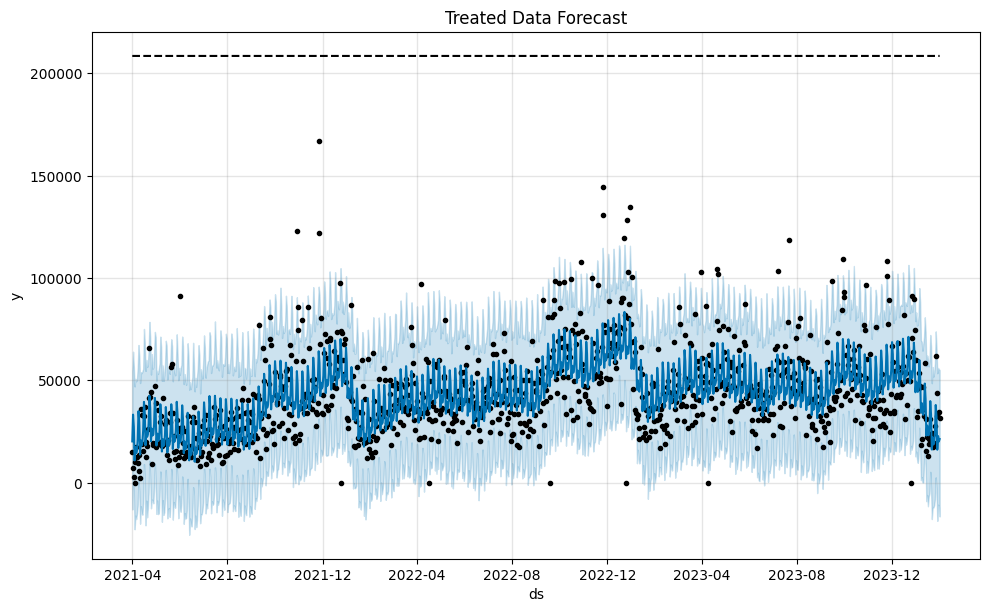

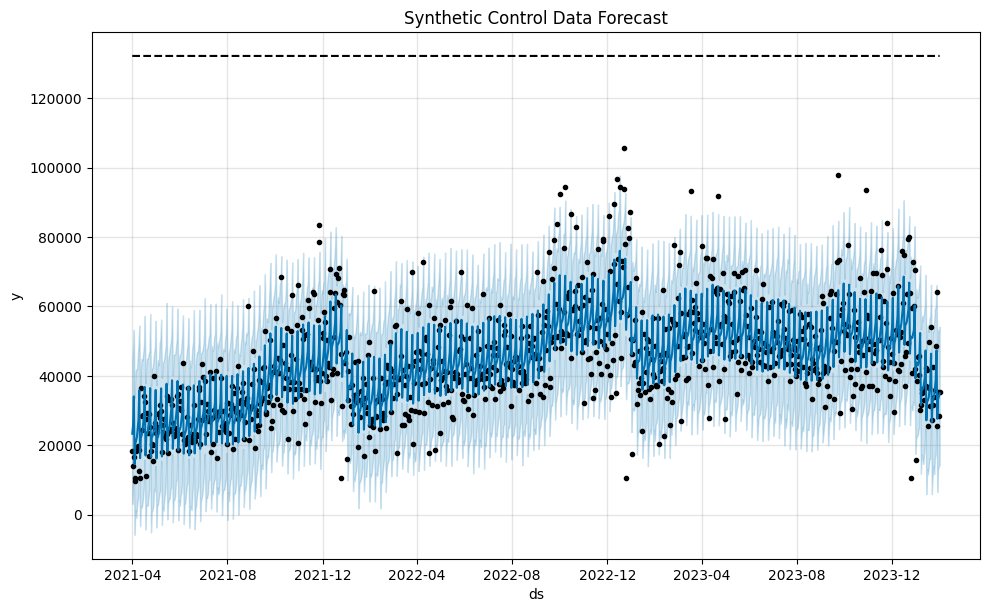

In [0]:
import matplotlib.pyplot as plt

def plot_prophet_forecast(model, data, title):
    forecast = model.predict(data)
    model.plot(forecast)
    plt.title(title)
    plt.show()

plot_prophet_forecast(model_treated, treated_prophet_data, "Treated Data Forecast")

plot_prophet_forecast(model_synthetic, synthetic_control_data, "Synthetic Control Data Forecast")


In [0]:
score = True
if score:
    # Evaluate model for treated data
    df_cv_treated = cross_validation(
        model_treated,
        horizon="60 days",
        period="60 days",
        initial="360 days",
        parallel="processes",
    )
    df_p_treated = performance_metrics(df_cv_treated, rolling_window=1)
    rmse_score_treated = df_p_treated["rmse"].values[0]
    print(f"Treated Group RMSE: {rmse_score_treated}")
    
    # Evaluate model for synthetic control data
    df_cv_synthetic = cross_validation(
        model_synthetic,
        horizon="60 days",
        period="60 days",
        initial="360 days",
        parallel="processes",
    )
    df_p_synthetic = performance_metrics(df_cv_synthetic, rolling_window=1)
    rmse_score_synthetic = df_p_synthetic["rmse"].values[0]
    print(f"Synthetic Control Group RMSE: {rmse_score_synthetic}")


INFO:prophet:Making 11 forecasts with cutoffs between 2022-04-11 00:00:00 and 2023-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4adcc08b80>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/274f63o7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/y8vi2i3j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/1gwnkshl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/21vfjh6q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/m0o72tui.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/fqpp917m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/gaswrl_e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/doy9ly69.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/01w8pukp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/k_2flhhv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/n2sv9kak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/m9agbwil.json
DEBUG:cmdstanpy:input tempfile: /

Treated Group RMSE: 17160.565440370516


DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/nlosbp2q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/z3tc5ku8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/ngfvy50f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/a7rwpaa6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/bfr9t_q7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/avmespwd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/sq62kntt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/z3w80u58.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/k9s5p9w_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/28hso_i1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/wbgz1qee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxhv20tk/htd8_3yq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/local_disk0/.ephemeral_nfs/envs/pythonEnv-4804c71b-87e8-4acb-ab5b-a5b45c0ddae4/lib/python3.10/site-packages/prophet/stan_model/prophet_mod

Synthetic Control Group RMSE: 11506.692900316626


In [0]:
# Create future dataframe and predict
future = model_treated.make_future_dataframe(periods=len(treatment_period), freq='D')
future["treatment"] = np.where(
    future["ds"].between(
        get_treatment_start, get_treatment_end, inclusive=True
    ),
    1,
    0,
)
future["cap"] = treated_prophet_data["y"].max() * 1.25
future["floor"] = 0

future_syn = model_synthetic.make_future_dataframe(periods=len(treatment_period), freq='D')
future_syn["treatment"] = np.where(
    future_syn["ds"].between(
        get_treatment_start, get_treatment_end, inclusive=True
    ),
    1,
    0,
)
future_syn["cap"] = synthetic_control_data["y"].max() * 1.25
future_syn["floor"] = 0

forecast_treated = model_treated.predict(future)
forecast_synthetic = model_synthetic.predict(future_syn)

# Extract prediction for treatment period
predicted_treated = forecast_treated.set_index('ds').loc[treatment_period[get_date_column]]['yhat']
predicted_synthetic = forecast_synthetic.set_index('ds').loc[treatment_period[get_date_column]]['yhat']
actual_treated = treatment_period['Agg_Pilot_Stores'].values
actual_synthetic = synthetic_control_converted[synthetic_control_converted.index >= get_treatment_start]

/root/.ipykernel/4661/command-593633870063270-3967529001:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  future["ds"].between(
/root/.ipykernel/4661/command-593633870063270-3967529001:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  future_syn["ds"].between(


In [0]:
from prophet.plot import plot_plotly, plot_components_plotly

fig = plot_plotly(model_treated, forecast_treated)
fig.show()

fig = plot_components_plotly(model_treated, forecast_treated)
fig.show()

fig = plot_plotly(model_synthetic, forecast_synthetic)
fig.show()

fig = plot_components_plotly(model_synthetic, forecast_synthetic)
fig.show()

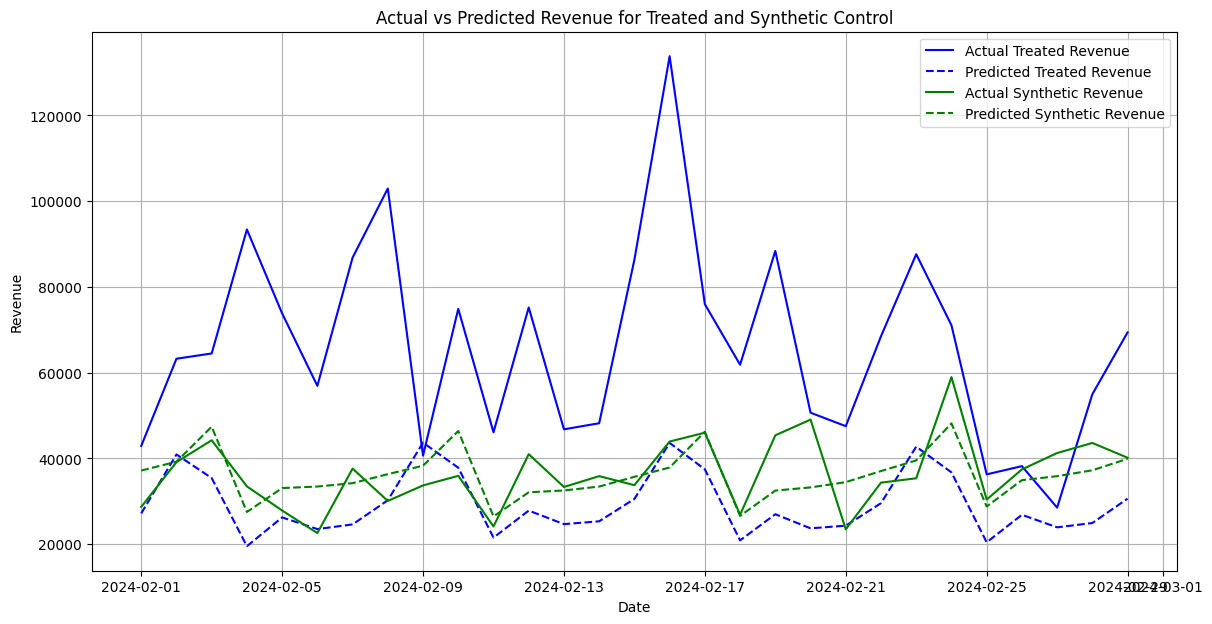

In [0]:
diff_treated = actual_treated - predicted_treated.values
diff_synthetic = actual_synthetic.values.flatten() - predicted_synthetic.values

# Plot the values
plt.figure(figsize=(14, 7))

# Plot actual and predicted treated revenue
plt.plot(treatment_period[get_date_column], actual_treated, label='Actual Treated Revenue', color='blue')
plt.plot(treatment_period[get_date_column], predicted_treated, label='Predicted Treated Revenue', linestyle='--', color='blue')

# Plot actual and predicted synthetic revenue
plt.plot(treatment_period[get_date_column], actual_synthetic, label='Actual Synthetic Revenue', color='green')
plt.plot(treatment_period[get_date_column], predicted_synthetic, label='Predicted Synthetic Revenue', linestyle='--', color='green')

plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue for Treated and Synthetic Control')
plt.legend()
plt.grid(True)
plt.show()

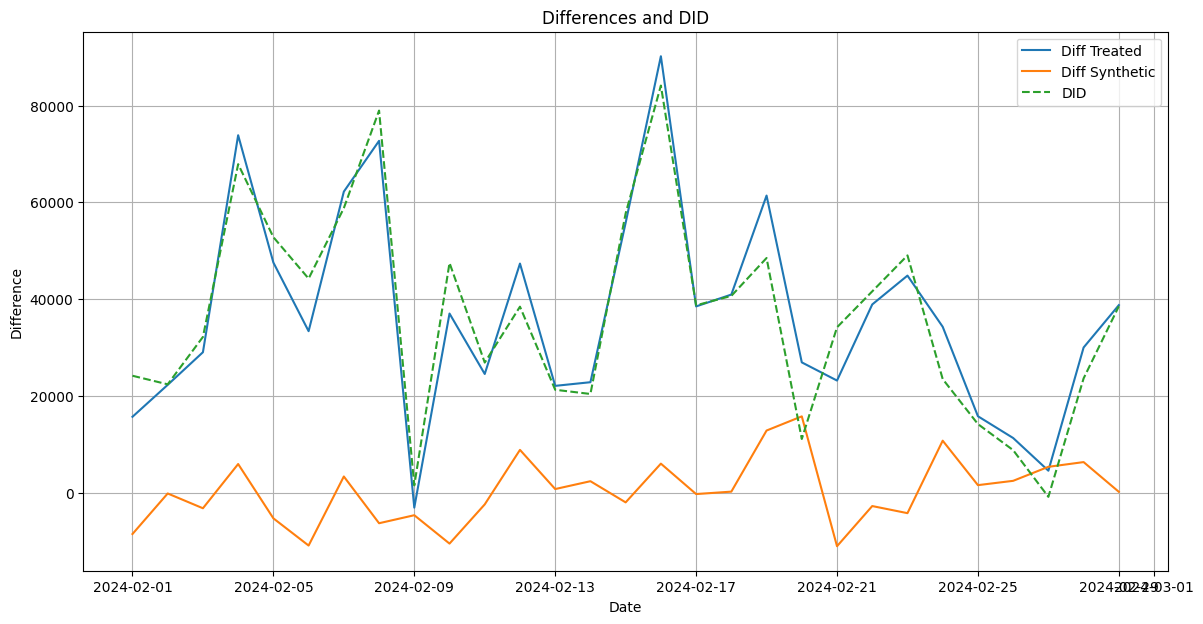

           Date  Actual Treated  Predicted Treated  Actual Synthetic  \
1036 2024-02-01         42912.4            27184.6           28692.3   
1037 2024-02-02         63247.0            40920.2           39132.9   
1038 2024-02-03         64480.5            35422.2           44236.0   
1039 2024-02-04         93387.0            19522.7           33478.3   
1040 2024-02-05         73824.0            26246.8           27848.7   
1041 2024-02-06         56926.8            23520.9           22584.9   
1042 2024-02-07         86827.9            24609.7           37629.6   
1043 2024-02-08        102947.6            30240.6           30083.0   
1044 2024-02-09         40656.3            43680.7           33704.1   
1045 2024-02-10         74877.0            37829.2           35940.2   
1046 2024-02-11         46101.0            21533.3           24128.5   
1047 2024-02-12         75198.9            27834.1           40996.5   
1048 2024-02-13         46789.9            24674.2           333

In [0]:
did = diff_treated - diff_synthetic

did_results = pd.DataFrame({
    'Date': treatment_period[get_date_column],
    'Actual Treated': actual_treated,
    'Predicted Treated': predicted_treated.values,
    'Actual Synthetic': actual_synthetic.values.flatten(),
    'Predicted Synthetic': predicted_synthetic.values,
    'Diff Treated': diff_treated,
    'Diff Synthetic': diff_synthetic,
    'DID': did
})

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(did_results['Date'], did_results['Diff Treated'], label='Diff Treated', linestyle='-')
plt.plot(did_results['Date'], did_results['Diff Synthetic'], label='Diff Synthetic', linestyle='-')
plt.plot(did_results['Date'], did_results['DID'], label='DID', linestyle='--')
plt.title('Differences and DID')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.grid(True)
plt.show()

print(did_results)

In [0]:
# Calculate the absolute and relative uplift
def calculate_uplift(did, actual_synthetic, predicted_synthetic, predicted_treated):
    absolute_uplift = np.sum(did)
    theoretical_counterfactual_treated = np.sum(actual_synthetic)-np.sum(predicted_synthetic)+np.sum(predicted_treated)
    relative_uplift = (absolute_uplift / theoretical_counterfactual_treated) * 100
    return absolute_uplift, theoretical_counterfactual_treated, relative_uplift

# Calculate absolute and relative uplift
absolute_uplift, theoretical_counterfactual_treated, relative_uplift = calculate_uplift(did, actual_synthetic, predicted_synthetic, predicted_treated)

print(f'Predicted Total Revenue without Treatement: {theoretical_counterfactual_treated[0]}')
print(f'Absolute Impact: {absolute_uplift}')
print(f'Relative Uplift: {relative_uplift[0]:.2f}%')
if isinstance(relative_uplift, pd.Series):
    relative_uplift = relative_uplift.iloc[0]

Predicted Total Revenue without Treatement: 863835.2063878704
Absolute Impact: 1051618.5136121297
Relative Uplift: 121.74%


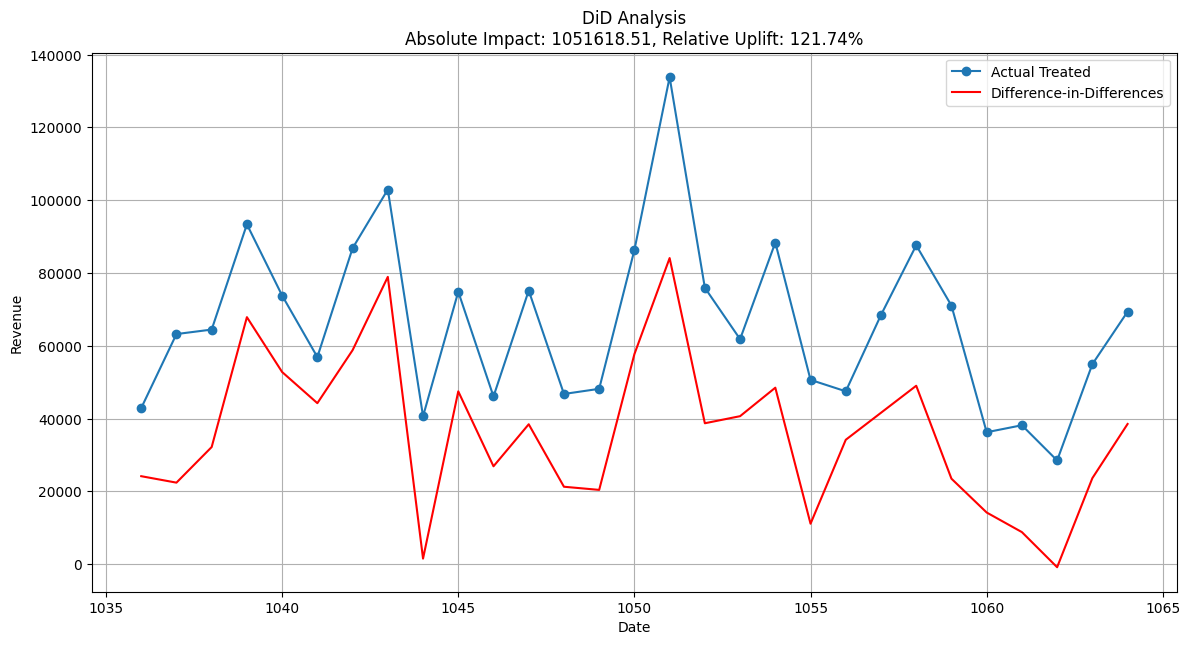

In [0]:
# Plotting the results including uplift
def plot_did_results_with_uplift(actual_treated, did, treatment_period):
    plt.figure(figsize=(14, 7))
    plt.plot(treatment_period.index, actual_treated, label='Actual Treated', marker='o')
    plt.plot(treatment_period.index, did, label='Difference-in-Differences', color='red')
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.title(f'DiD Analysis\nAbsolute Impact: {absolute_uplift:.2f}, Relative Uplift: {relative_uplift:.2f}%')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the DiD results with uplift
plot_did_results_with_uplift(actual_treated, did, treatment_period)


In [0]:
forecast_treated['ds'] = pd.to_datetime(forecast_treated['ds'])
forecast_treated = forecast_treated.set_index('ds')
forecast_synthetic['ds'] = pd.to_datetime(forecast_synthetic['ds']) 
forecast_synthetic = forecast_synthetic.set_index('ds')
domain_df = domain_df.set_index(get_date_column)

Pre-Treatment Daily RMSE: 10808.041295259933
Treatment Daily RMSE: 36883.67961944451
Pre-Treatment Weekly RMSE: 11375.214846007142
Treatment Weekly RMSE: 16621.89346171661


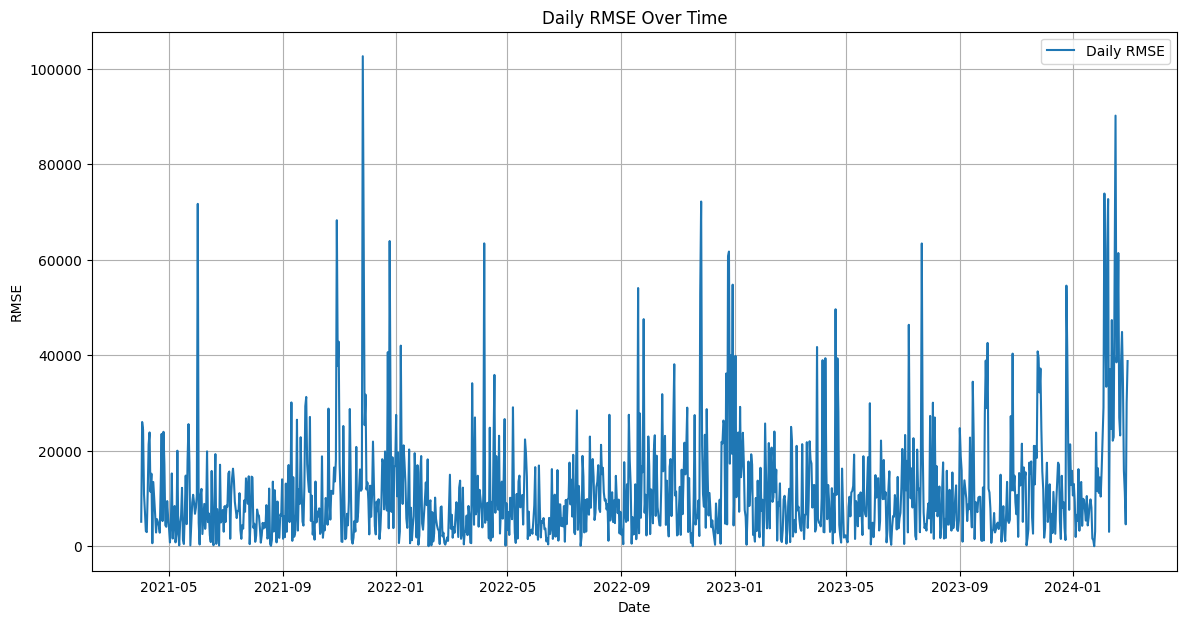

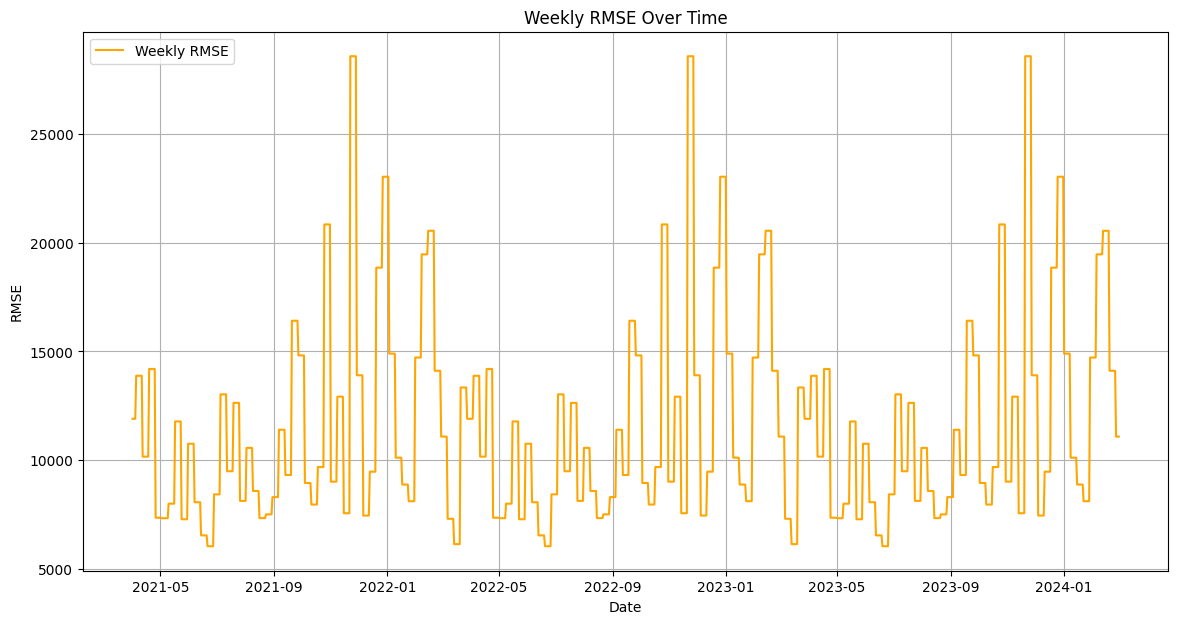

In [0]:
# Create a new DataFrame
all_results_treated = pd.DataFrame({
    'all_actual_treated': domain_df['Agg_Pilot_Stores'],
    'all_predicted_treated': forecast_treated['yhat']
})

# Calculate daily RMSE
all_results_treated['daily_rmse'] = np.sqrt(
    (all_results_treated['all_actual_treated'] - 
     all_results_treated['all_predicted_treated']) ** 2
)

# Calculate weekly RMSE
all_results_treated['week_number'] = all_results_treated.index.isocalendar().week
weekly_rmse = all_results_treated.groupby('week_number')['daily_rmse'].mean()

# Merge daily and weekly RMSE results
all_results_treated['weekly_rmse'] = all_results_treated['week_number'].map(weekly_rmse)

# Pre-treatment period
pre_treatment_period = all_results_treated.index < get_treatment_start

# Treatment period
treatment_period = (all_results_treated.index >= get_treatment_start) & \
                   (all_results_treated.index <= get_treatment_end)
                   
# Calculate average daily and weekly RMSE
daily_rmse_pre_treatment = all_results_treated.loc[pre_treatment_period, 'daily_rmse'].mean()
daily_rmse_treatment = all_results_treated.loc[treatment_period, 'daily_rmse'].mean()

weekly_rmse_pre_treatment = all_results_treated.loc[pre_treatment_period, 'weekly_rmse'].mean()
weekly_rmse_treatment = all_results_treated.loc[treatment_period, 'weekly_rmse'].mean()

# Output the results
print(f"Pre-Treatment Daily RMSE: {daily_rmse_pre_treatment}")
print(f"Treatment Daily RMSE: {daily_rmse_treatment}")

print(f"Pre-Treatment Weekly RMSE: {weekly_rmse_pre_treatment}")
print(f"Treatment Weekly RMSE: {weekly_rmse_treatment}")

# Plot Daily RMSE
plt.figure(figsize=(14, 7))
plt.plot(all_results_treated.index, all_results_treated['daily_rmse'], label='Daily RMSE')
plt.xlabel('Date')
plt.ylabel('RMSE')
plt.title('Daily RMSE Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot Weekly RMSE
plt.figure(figsize=(14, 7))
plt.plot(all_results_treated.index, all_results_treated['weekly_rmse'], label='Weekly RMSE', color='orange')
plt.xlabel('Date')
plt.ylabel('RMSE')
plt.title('Weekly RMSE Over Time')
plt.legend()
plt.grid(True)
plt.show()


Pre-Treatment Daily RMSE: 6796.860470528914
Treatment Daily RMSE: 5344.758312507779
Pre-Treatment Weekly RMSE: 6775.77149680631
Treatment Weekly RMSE: 6098.143718598071


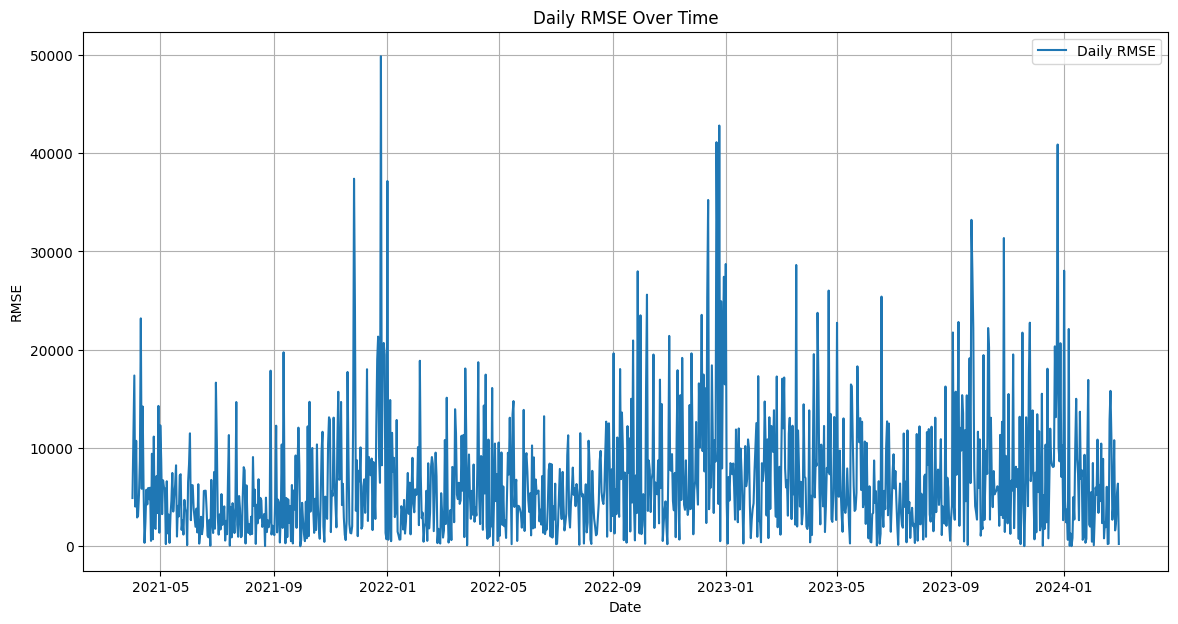

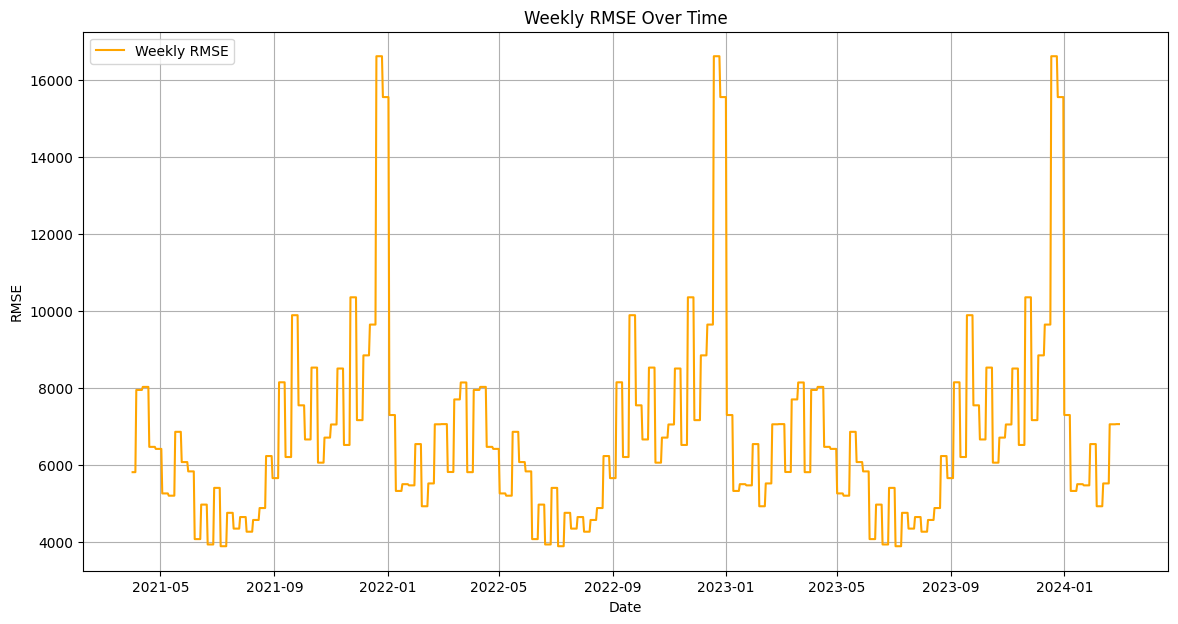

In [0]:
# Create a new DataFrame
all_results_synthetic = pd.DataFrame({
    'all_actual_synthetic': synthetic_control_converted['synthetic_revenue'],
    'all_predicted_synthetic': forecast_synthetic['yhat']
})

# Calculate daily RMSE
all_results_synthetic['daily_rmse'] = np.sqrt(
    (all_results_synthetic['all_actual_synthetic'] - 
     all_results_synthetic['all_predicted_synthetic']) ** 2
)

# Calculate weekly RMSE
all_results_synthetic['week_number'] = all_results_synthetic.index.isocalendar().week
weekly_rmse = all_results_synthetic.groupby('week_number')['daily_rmse'].mean()

# Merge daily and weekly RMSE results
all_results_synthetic['weekly_rmse'] = all_results_synthetic['week_number'].map(weekly_rmse)
                   
# Calculate average daily and weekly RMSE
daily_rmse_pre_treatment = all_results_synthetic.loc[pre_treatment_period, 'daily_rmse'].mean()
daily_rmse_treatment = all_results_synthetic.loc[treatment_period, 'daily_rmse'].mean()

weekly_rmse_pre_treatment = all_results_synthetic.loc[pre_treatment_period, 'weekly_rmse'].mean()
weekly_rmse_treatment = all_results_synthetic.loc[treatment_period, 'weekly_rmse'].mean()

# Output the results
print(f"Pre-Treatment Daily RMSE: {daily_rmse_pre_treatment}")
print(f"Treatment Daily RMSE: {daily_rmse_treatment}")

print(f"Pre-Treatment Weekly RMSE: {weekly_rmse_pre_treatment}")
print(f"Treatment Weekly RMSE: {weekly_rmse_treatment}")

# Plot Daily RMSE
plt.figure(figsize=(14, 7))
plt.plot(all_results_synthetic.index, all_results_synthetic['daily_rmse'], label='Daily RMSE')
plt.xlabel('Date')
plt.ylabel('RMSE')
plt.title('Daily RMSE Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot Weekly RMSE
plt.figure(figsize=(14, 7))
plt.plot(all_results_synthetic.index, all_results_synthetic['weekly_rmse'], label='Weekly RMSE', color='orange')
plt.xlabel('Date')
plt.ylabel('RMSE')
plt.title('Weekly RMSE Over Time')
plt.legend()
plt.grid(True)
plt.show()
